### In this notebook we will show different examples how we tried to preprocess the data to feed it later on to the model.

#### Import Libraries

In [1]:
%matplotlib inline
import numpy as np
from utils.helper import read_data, blur, morphology
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
FOLDER = "data/data_big/"

#### Read the data
##### We decided to take 10 Frames as 1 sample. We think this is a reasonable trade-off between the number of training samples and the number of moving objects included in one sample 


In [2]:
data_empty = read_data(FOLDER + "empty.csv", 10)
data_1p = read_data(FOLDER + "1p.csv", 10)
data_2p = read_data(FOLDER + "2p.csv", 10)
data_3p = read_data(FOLDER + "3p.csv", 10)
print("----------------Shapes----------------")
print("empty:", data_empty.shape)
print("1p:", data_1p.shape)
print("2p:", data_2p.shape)
print("3p:", data_3p.shape)

----------------Shapes----------------
empty: (240, 10, 3, 64, 64)
1p: (240, 10, 3, 64, 64)
2p: (240, 10, 3, 64, 64)
3p: (240, 10, 3, 64, 64)


Take the absolute value of each data point, because the values are complex numbers.

In [100]:
data_empty_abs = np.abs(data_empty)
data_1p_abs = np.abs(data_1p)
data_2p_abs = np.abs(data_2p)
data_3p_abs = np.abs(data_3p)
print(f"data_empty_abs: {data_empty_abs.shape}")
print(f"data_1p_abs: {data_1p_abs.shape}")
print(f"data_2p_abs: {data_2p_abs.shape}")
print(f"data_3p_abs: {data_3p_abs.shape}")

data_empty_abs: (240, 10, 3, 64, 64)
data_1p_abs: (240, 10, 3, 64, 64)
data_2p_abs: (240, 10, 3, 64, 64)
data_3p_abs: (240, 10, 3, 64, 64)


Avaraging over the 10 frames to get samples

In [101]:
data_empty_samples = np.sum(data_empty_abs, axis=1)
data_1p_samples = np.sum(data_1p_abs, axis=1)
data_2p_samples = np.sum(data_2p_abs, axis=1)
data_3p_samples = np.sum(data_3p_abs, axis=1)
print(f"data_empty_samples: {data_empty_samples.shape}")
print(f"data_1p_samples: {data_1p_samples.shape}")
print(f"data_2p_samples: {data_2p_samples.shape}")
print(f"data_3p_samples: {data_3p_samples.shape}")

data_empty_samples: (240, 3, 64, 64)
data_1p_samples: (240, 3, 64, 64)
data_2p_samples: (240, 3, 64, 64)
data_3p_samples: (240, 3, 64, 64)


As an input to the CNN we decided to use the 3D image where the third dimension is the radar channel (We have 3 channels). Another possibility is to use 3 seperate 2D inputs to the CNN, each for the corresponding channel. We did not try this because of time constraints.

In [102]:
data_empty_reshaped = np.moveaxis(data_empty_samples, 1,3)
data_1p_reshaped = np.moveaxis(data_1p_samples, 1,3)
data_2p_reshaped = np.moveaxis(data_2p_samples, 1,3)
data_3p_reshaped = np.moveaxis(data_3p_samples, 1,3)
print(f"data_empty_reshaped: {data_empty_reshaped.shape}")
print(f"data_1p_reshaped: {data_1p_reshaped.shape}")
print(f"data_2p_reshaped: {data_2p_reshaped.shape}")
print(f"data_3p_reshaped: {data_3p_reshaped.shape}")

data_empty_reshaped: (240, 64, 64, 3)
data_1p_reshaped: (240, 64, 64, 3)
data_2p_reshaped: (240, 64, 64, 3)
data_3p_reshaped: (240, 64, 64, 3)


##### Return to normal shape (N,3,64,64) to do preprocessing

In [103]:
data_empty_reshaped = data_empty_samples
data_1p_reshaped = data_1p_samples
data_2p_reshaped = data_2p_samples
data_3p_reshaped = data_3p_samples
print(f"data_empty_reshaped: {data_empty_reshaped.shape}")
print(f"data_1p_reshaped: {data_1p_reshaped.shape}")
print(f"data_2p_reshaped: {data_2p_reshaped.shape}")
print(f"data_3p_reshaped: {data_3p_reshaped.shape}")

data_empty_reshaped: (240, 3, 64, 64)
data_1p_reshaped: (240, 3, 64, 64)
data_2p_reshaped: (240, 3, 64, 64)
data_3p_reshaped: (240, 3, 64, 64)


Let's have a look at the data. For the sake of simplicity we will only show one channel.

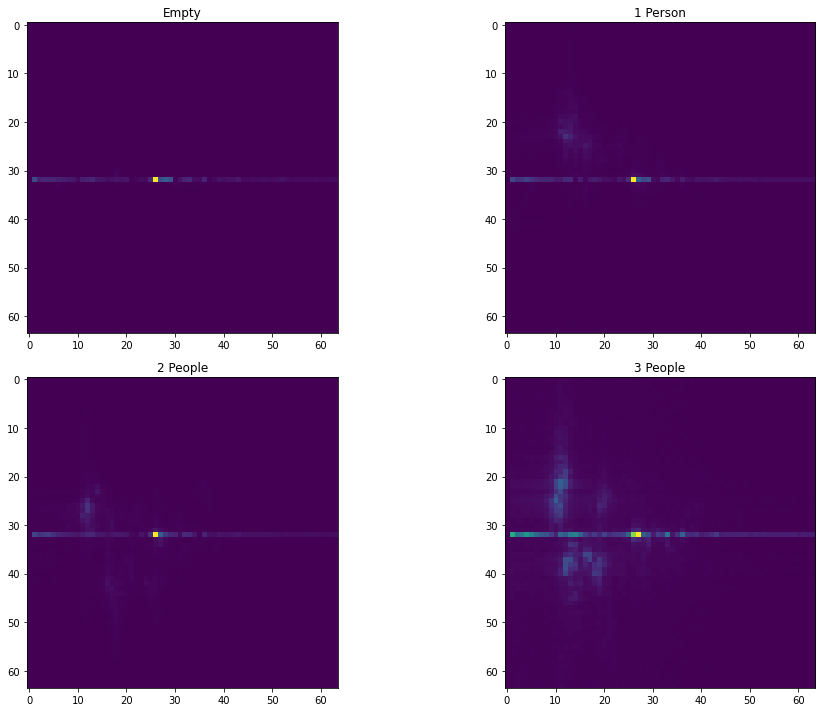

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
random_sample = np.random.randint(0, data_empty_reshaped.shape[0])
rando_sample = 155
axs[0, 0].imshow(data_empty_reshaped[random_sample,1, :, :])
axs[0,0].set_title("Empty")
axs[0, 1].imshow(data_1p_reshaped[random_sample,1, :, :])
axs[0,1].set_title("1 Person")
axs[1, 0].imshow(data_2p_reshaped[random_sample,1, :, :])
axs[1,0].set_title("2 People")
axs[1, 1].imshow(data_3p_reshaped[random_sample,1, :, :])
axs[1,1].set_title("3 People")
fig.tight_layout()
plt.savefig("figs/raw_data.png")

    We obtain a very thick line where the velocity is 0. This is the 32th line. The data on this line corresponds to all static objects observed by the radar. We should filter out this line to see the moving object more clearly.

In [105]:
def plot_data(data_empty, data_1p, data_2p, data_3p, sample_number, title, file_name):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    pos1 = axs[0, 0].imshow(data_empty[random_sample,1, :, :])
    fig.colorbar(pos1, ax=axs[0, 0])
    axs[0,0].set_title("Empty")
    pos2 = axs[0, 1].imshow(data_1p[random_sample,1, :, :])
    fig.colorbar(pos2, ax=axs[0, 1])
    axs[0,1].set_title("1 Person")
    pos3 = axs[1, 0].imshow(data_2p[random_sample,1, :, :])
    fig.colorbar(pos3, ax=axs[1, 0])
    axs[1,0].set_title("2 People")
    pos4 = axs[1, 1].imshow(data_3p[random_sample,1, :, :])
    fig.colorbar(pos4, ax=axs[1, 1])
    axs[1,1].set_title("3 People")
    fig.suptitle(title)
    fig.tight_layout()
    plt.savefig(f"figs/{file_name}")

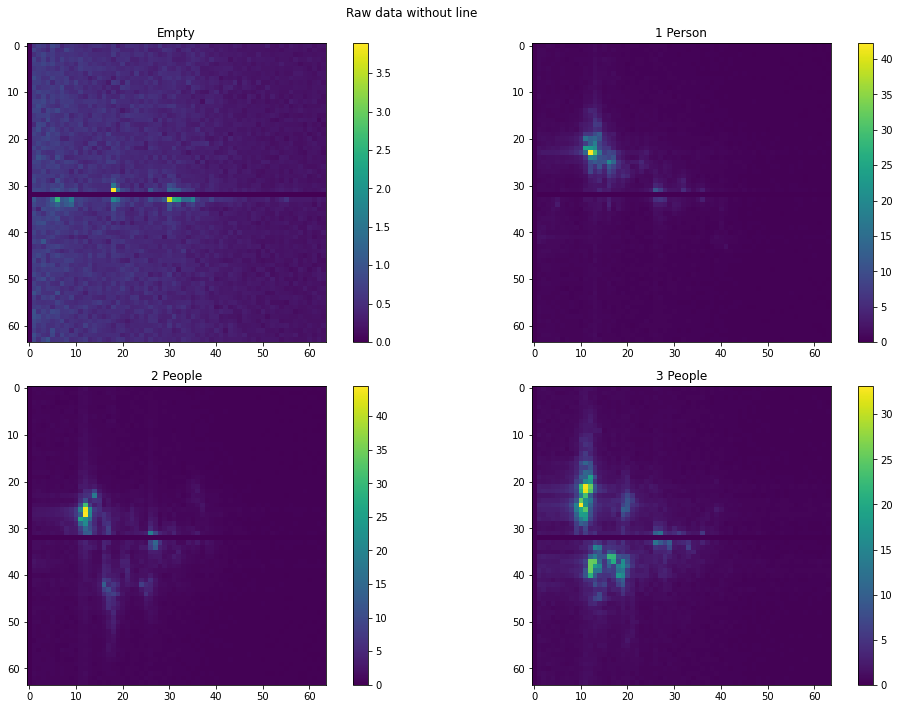

In [106]:
data_empty_reshaped[:,:,32,:] = 0
data_1p_reshaped[:,:,32,:] = 0
data_2p_reshaped[:,:,32,:] = 0
data_3p_reshaped[:,:,32,:] = 0
plot_data(  data_empty_reshaped, 
            data_1p_reshaped, 
            data_2p_reshaped, 
            data_3p_reshaped, 
            random_sample, 
            "Raw data without line",
            "raw_data_without_line.png"
        )


    We can already see clearly moving objects in the image. 

#### Different data preprocesing techniques

Just data normalization in the range from 0 to 1.

In [107]:
def normalize_data_2D(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def normalize_data_channels(frame):
    for i in range(3):
        frame[i,:,:] = normalize_data_2D(frame[i,:,:])
    return frame

data_empty_normalized: (240, 3, 64, 64)
data_1p_normalized: (240, 3, 64, 64)
data_2p_normalized: (240, 3, 64, 64)
data_3p_normalized: (240, 3, 64, 64)


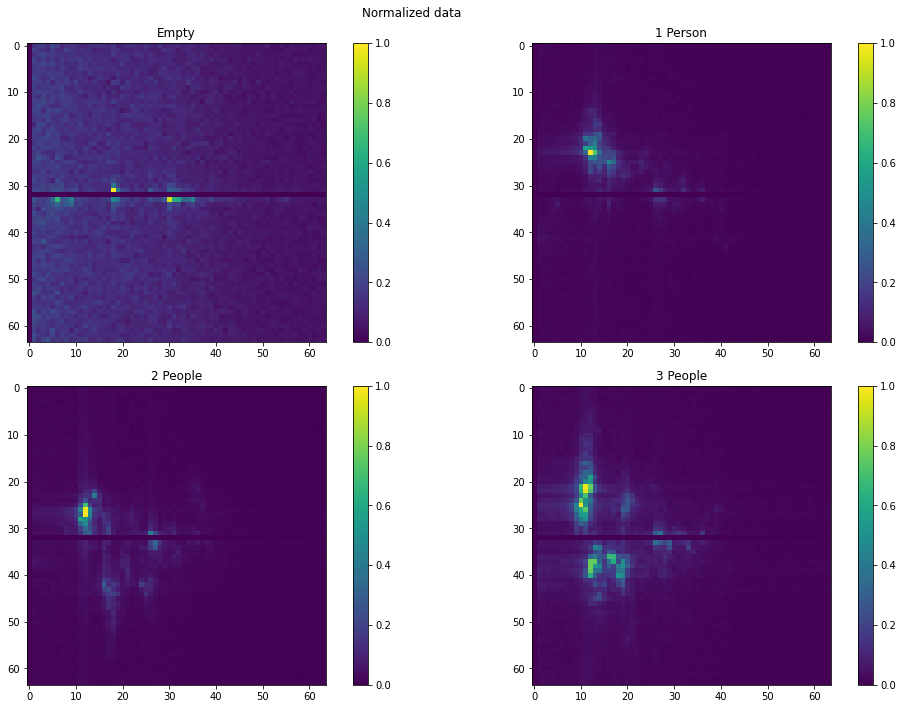

In [108]:
data_empty_normalized = np.array([normalize_data_channels(sample) for sample in data_empty_reshaped])
data_1p_normalized = np.array([normalize_data_channels(sample) for sample in data_1p_reshaped])
data_2p_normalized = np.array([normalize_data_channels(sample) for sample in data_2p_reshaped])
data_3p_normalized = np.array([normalize_data_channels(sample) for sample in data_3p_reshaped])

print(f"data_empty_normalized: {data_empty_normalized.shape}")
print(f"data_1p_normalized: {data_1p_normalized.shape}")
print(f"data_2p_normalized: {data_2p_normalized.shape}")
print(f"data_3p_normalized: {data_3p_normalized.shape}")

plot_data(  data_empty_normalized,
            data_1p_normalized,
            data_2p_normalized,
            data_3p_normalized,
            random_sample,
                "Normalized data",
            "normalized_data.png"
        )


##### Gaus Blurring

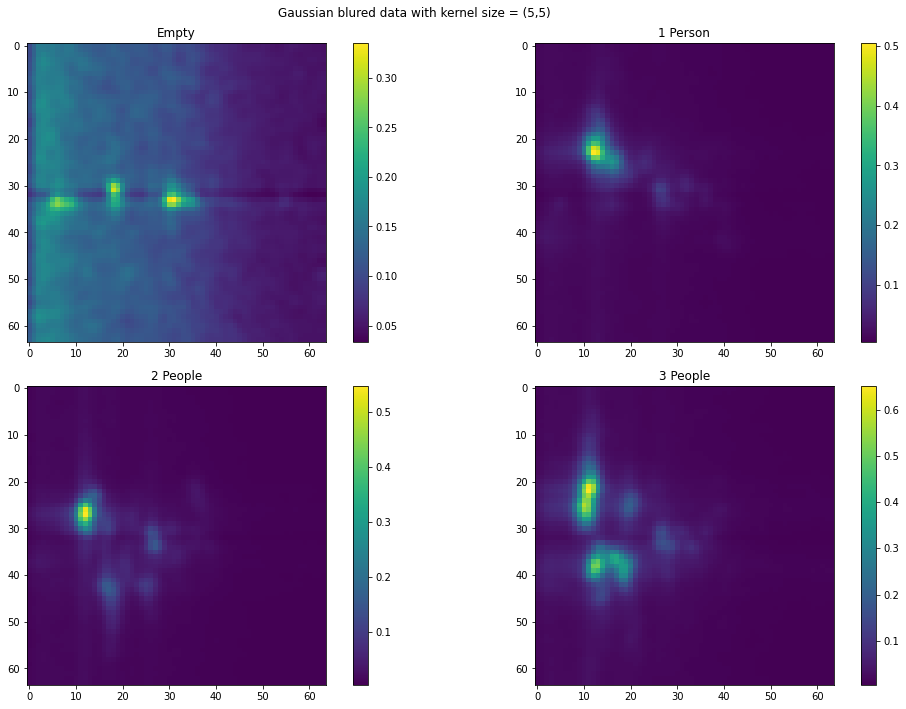

In [109]:
from utils.helper import blur

data_empty_gauss_blured = blur(data_empty_normalized)
data_1p_gauss_blured = blur(data_1p_normalized)
data_2p_gauss_blured = blur(data_2p_normalized)
data_3p_gauss_blured = blur(data_3p_normalized)

plot_data(  data_empty_gauss_blured,
            data_1p_gauss_blured,
            data_2p_gauss_blured,
            data_3p_gauss_blured,
            random_sample,
                "Gaussian blured data with kernel size = (5,5)",
            "gauss_blured_data.png"
        )

#### Saliency map

In [110]:
def calculate_saliency_map(data):
    data_out = np.zeros(data.shape[1:])
    for i in range(3):
        diffs = np.diff(data[:,i,:,:], axis=0).squeeze()
        # print(diffs.shape)
        diffs = np.abs(diffs)
        multiplications_morphologies = []
        for j in range(diffs.shape[0]):
            mult = np.multiply(diffs[j,:,:], diffs[j,:,:])
            # print(mult.shape)
            morph = cv2.morphologyEx(mult, cv2.MORPH_OPEN, np.ones((3,3)))
            multiplications_morphologies.append(morph)
        multiplications_morphologies = np.array(multiplications_morphologies)
        data_out[i,:,:] = np.sum(multiplications_morphologies, axis = 0)

    return normalize_data_channels(data_out)


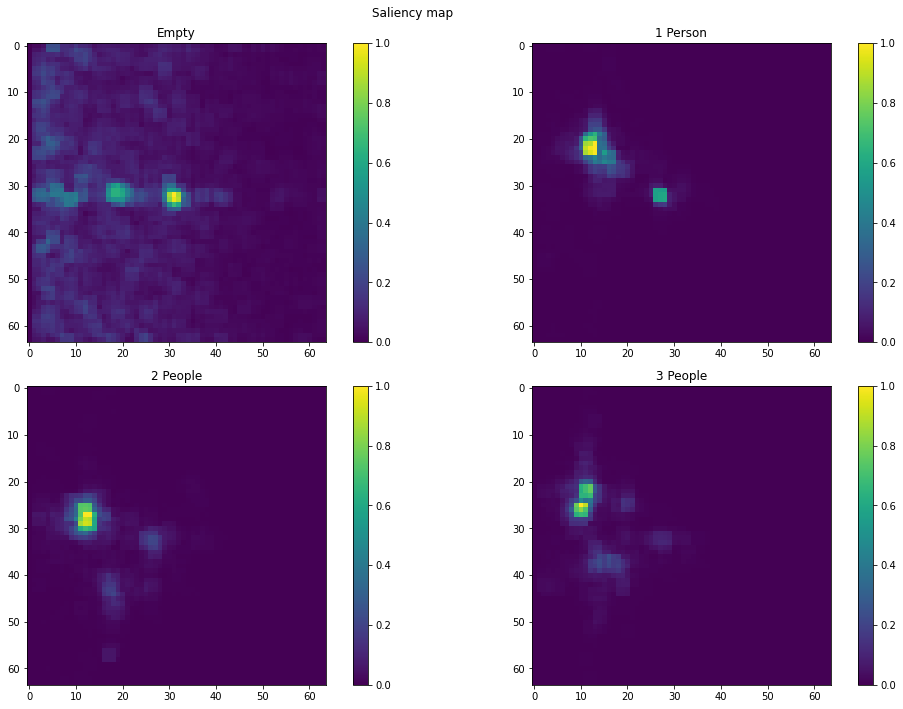

In [111]:
data_empty_saliency = np.array([calculate_saliency_map(sample) for sample in data_empty_abs])
data_1p_saliency = np.array([calculate_saliency_map(sample) for sample in data_1p_abs])
data_2p_saliency = np.array([calculate_saliency_map(sample) for sample in data_2p_abs])
data_3p_saliency = np.array([calculate_saliency_map(sample) for sample in data_3p_abs])

plot_data(  data_empty_saliency,
            data_1p_saliency,
            data_2p_saliency,
            data_3p_saliency,
            random_sample,
                "Saliency map",
            "saliency_map.png"
        )

##### Sobel Derivatives


In [112]:
def apply_sobel_derivs(sample):
    for i in range(sample.shape[0]):
        sample[i,:,:] = cv2.Sobel(sample[i,:,:], cv2.CV_64F, 1, 0, ksize=5) # x derivative
    return normalize_data_channels(sample)

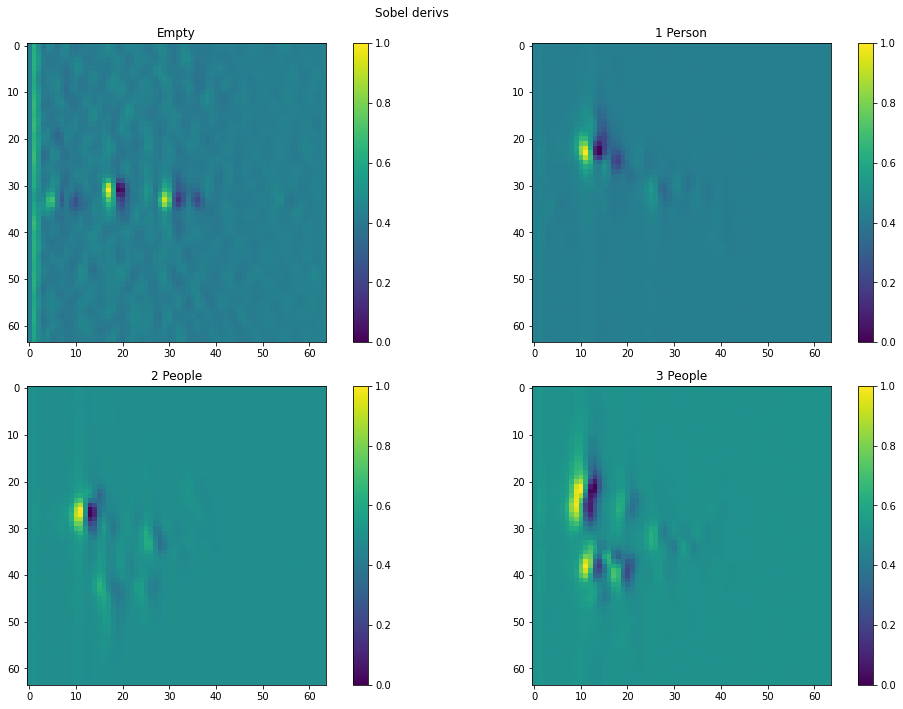

In [113]:
data_empty_sobel = np.array([apply_sobel_derivs(sample) for sample in data_empty_normalized])
data_1p_sobel = np.array([apply_sobel_derivs(sample) for sample in data_1p_normalized])
data_2p_sobel = np.array([apply_sobel_derivs(sample) for sample in data_2p_normalized])
data_3p_sobel = np.array([apply_sobel_derivs(sample) for sample in data_3p_normalized])

plot_data(  data_empty_sobel,
            data_1p_sobel,
            data_2p_sobel,
            data_3p_sobel,
            random_sample,
                "Sobel derivs",
            "sobel_derivs.png"
)